# Table of Contents

    1. Introduction
    2. Data Loading and Cleaning
    3. Text Analysis - Natural Language Processing
        3.1 Sentiment Analysis using review data
        3.2 Cleaning of text features
        3.3 Data preparation for test data
        3.4 Padding
        3.5 Embedding
    4. Model Evaluation
        4.1 Linear Regression
            4.1.1 Linear Regression without variable selection
            4.1.2 Linear Regression with variable selection
        4.2 Neural Network
            4.2.1 Feedforward Neural Network
            4.2.2 Gated Recurrent Unit
            4.2.3 Bidirectional Long Short-Term Memory
    5. Model Comparison and Selection
    6. GRU application to Test Set
    7. Conclusion

## This project is done on September 2022, I have since acquired more skills and knowledge and been working on an improvement of this project. 

# 1. Introduction

The goal of this assignment is to predict Airbnb listings price in London using the techniques learnt in ADAMS (Natural Language Processing and Neural Networks) based on text and non-text features.

In [42]:
from bs4 import BeautifulSoup
from category_encoders import MEstimateEncoder
from datetime import date
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, Bidirectional, GRU
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from spacy.lang.en import English
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from statistics import mode
from tensorflow import keras
from tensorflow.keras import activations, losses
from tensorflow.keras import layers
import emot_dictionary as emot
import flair
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pysentiment2 as ps
import re
import seaborn as sns
import spacy
import statsmodels.api as sm
import string
import tensorflow as tf
import time

%matplotlib inline

In [57]:
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
import torch

# 2. Data Loading and cleaning

First, the train and test data set as well as the additional reviews data set are loaded and the train data set is splitted into X_train, X_test, y_train and y_test respectively so that model selection could be performed based on X_test and y_test while only using the information from X_train and y_train. Prior to model selection, only information from X_train and y_train will be used for the analysis and prediction and after model selection, X_train and X_test, as well as y_train and y_test could be combined for the prediction task so that the data could be used more efficiently. The dataset can be found on: https://www.kaggle.com/competitions/adams-sose22/data.

In [20]:
train = pd.read_csv("train.csv", sep=",", encoding = "utf-8")
#test = pd.read_csv("test.csv", sep=",", encoding = "utf-8")
#review = pd.read_csv("reviews.csv", sep = ",", encoding = "utf-8")

In [ ]:
urls = train["picture_url"][0:5]

In [80]:
def url_to_tensor(urls):
    tensors = []
    transform = transforms.Compose([transforms.PILToTensor()])
    
    for i in range(len(urls)):
        response = requests.get(urls[i])
        
        if response.status_code == 404:
            tensors.append("Missing")
        else:
            img = Image.open(BytesIO(response.content))
            t = transform(img)
            t = t.squeeze().permute(1, 2, 0)
            tensors.append(t)
    
    return tensors

In [73]:
a = [train["picture_url"][0]]

In [81]:
pics = url_to_tensor(urls)

In [85]:
type(pics[0])

torch.Tensor

In [87]:
d = []

for i in pics:
    if type(i) == torch.Tensor:
        d.append(i.shape)
    else:
        d.append(i)

In [88]:
d

[torch.Size([480, 640, 3]),
 'Missing',
 torch.Size([480, 640, 3]),
 torch.Size([480, 640, 3]),
 torch.Size([480, 914, 3])]

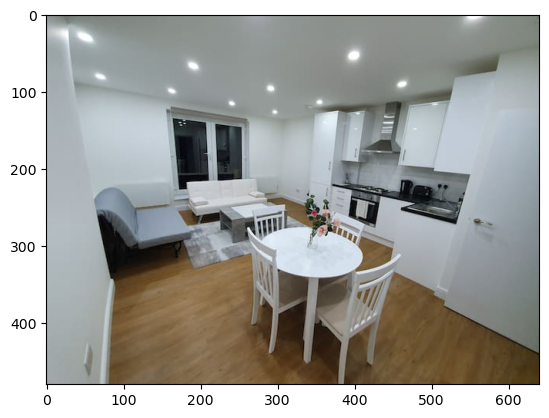

In [44]:
url = train["picture_url"][2]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
transform = transforms.Compose([transforms.PILToTensor()])
a = transform(img)
a = a.squeeze().permute(1, 2, 0)
plt.imshow(a)

In [45]:
a.shape

torch.Size([480, 640, 3])

In [3]:
X = train.drop("price", axis = 1)
y = train.price

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 934)

After splitting the data, the descriptive statistics and misisng data are being looked into.

In [5]:
X_train.describe(include = 'all')

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
count,44217,41841,30677,42827,44227,28614,28372,25564,44227,4.422700e+04,...,33506.00000,33478.000000,33483.000000,33449.000000,33479.000000,33452.000000,33453.000000,44227,34340.000000,44227
unique,43381,39552,28769,41448,5,24635,25278,20153,43650,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,44227
top,Double room,"Featured in The New York Times, The Wall Stree...",Situated in an excellent central location. Tow...,My Luxury Two Bedroom apartment is located min...,none,Conveniently located in Maida Vale one of Lond...,Transport links are excellent with convenient ...,- The lead guest will be required to sign an O...,https://a0.muscache.com/im/pictures/d029c664-c...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict_14_with_grace_period,NaN,JYEVUNA9PH
freq,23,104,15,14,43366,32,36,167,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19240,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.818925e+07,...,92.54062,9.504391,9.262880,9.623128,9.653693,9.538682,9.264371,NaN,1.171109,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.018841e+07,...,10.07104,0.979810,1.137731,0.894640,0.872253,0.813971,1.032474,NaN,1.362198,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.697000e+03,...,20.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,0.010000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.513013e+07,...,90.00000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,0.240000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.816502e+07,...,96.00000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,0.730000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.449555e+08,...,100.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.580000,NaN


<AxesSubplot:>

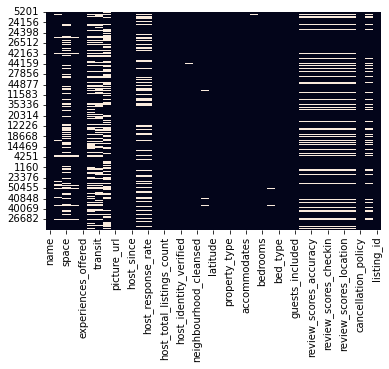

In [6]:
sns.heatmap(X_train.isnull(), cbar = False)

In [7]:
X_train.isnull().sum()/X_train.shape[0]

name                           0.000226
summary                        0.053949
space                          0.306374
description                    0.031655
experiences_offered            0.000000
neighborhood_overview          0.353020
transit                        0.358491
house_rules                    0.421982
picture_url                    0.000000
host_id                        0.000000
host_since                     0.002035
host_response_time             0.320551
host_response_rate             0.320551
host_is_superhost              0.002035
host_total_listings_count      0.002035
host_has_profile_pic           0.002035
host_identity_verified         0.002035
neighbourhood                  0.002623
neighbourhood_cleansed         0.000000
zipcode                        0.022905
latitude                       0.000000
longitude                      0.000000
property_type                  0.000000
room_type                      0.000000
accommodates                   0.000000


Upon inspecting the null values in the data set, noticed that space, neighnorhood_overview, transit, house_rules, host_response_time, host_response_rate, and several reviews related variables have about 20 - 40% missing data and so it is not a good idea to predict result based on these variables. They are therefore excluded from the data sets.

Several other variables such as image and geographical data are excluded because the type of data would not be analysed here. 'neighbourhood_cleansed' are exlcuded because it is similar to 'neighbourhood' and contain less information. 'host_id' and 'listing_id' are excluded because they are not relevant for price prediction. listing_id is saved to be used later as key id for inner join with the result from sentiment analysis

In [8]:
missing_rate = X_train.isnull().sum()/X_train.shape[0]
missing_drop = list(missing_rate[missing_rate > 0.2].index)
X_train = X_train.drop(missing_drop, axis = 1)

In [9]:
for df in [X_train, X_test, y_train, y_test, test]:
    df.reset_index(drop=True, inplace=True)

X_train_listing_id = X_train.listing_id 
X_test_listing_id = X_test.listing_id
test_listing_id = test.listing_id

In [10]:
X_train = X_train.drop(["picture_url", "host_id", "neighbourhood_cleansed", "zipcode", "latitude",
                    "longitude", "listing_id"], axis = 1)

For text and categorical variables, the missing values could be filled in as a new category or text: 'Missing', while mode is used to fill in the missing value for the variable "host_since" (date variable), 'host_total_listings_count', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'bathrooms', 'bedrooms', 'beds'.

In [12]:
for text_col in ['name', 'summary', 'description', 'neighbourhood', 'bed_type', 'amenities']:
    
    X_train[text_col].fillna('Missing', inplace = True, downcast = 'infer')

In [13]:
for col in ['host_since', 'host_total_listings_count','host_is_superhost','host_has_profile_pic', 
            'host_identity_verified', 'bathrooms', 'bedrooms', 'beds']:
     X_train.loc[X_train[col].isnull() == True, col] = mode(X_train[col])

Another quick overview of the data set reveals that several of the variables are not in appropriate data type, and thus they are being transformed into suitable data type.

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44227 entries, 0 to 44226
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       44227 non-null  object 
 1   summary                    44227 non-null  object 
 2   description                44227 non-null  object 
 3   experiences_offered        44227 non-null  object 
 4   host_since                 44227 non-null  object 
 5   host_is_superhost          44227 non-null  object 
 6   host_total_listings_count  44227 non-null  float64
 7   host_has_profile_pic       44227 non-null  object 
 8   host_identity_verified     44227 non-null  object 
 9   neighbourhood              44227 non-null  object 
 10  property_type              44227 non-null  object 
 11  room_type                  44227 non-null  object 
 12  accommodates               44227 non-null  int64  
 13  bathrooms                  44227 non-null  flo

In [15]:
X_train.describe(include = 'all')

,name,summary,description,experiences_offered,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,guests_included,cancellation_policy
count,44227,44227,44227,44227,44227,44227,44227.000000,44227,44227,44227,44227,44227,44227.000000,44227.000000,44227.000000,44227.000000,44227,44227,44227.000000,44227
unique,43382,39553,41449,5,3415,2,NaN,2,2,150,37,4,NaN,NaN,NaN,NaN,5,40696,NaN,8
top,Double room,Missing,Missing,none,2015-05-21,f,NaN,t,f,City of Westminster,Apartment,Entire home/apt,NaN,NaN,NaN,NaN,Real Bed,{},NaN,strict_14_with_grace_period
freq,23,2386,1400,43366,415,37617,NaN,44099,28404,2615,29629,24386,NaN,NaN,NaN,NaN,43882,174,NaN,19240
mean,NaN,NaN,NaN,NaN,NaN,NaN,20.470256,NaN,NaN,NaN,NaN,NaN,3.127547,1.283277,1.370995,1.704886,NaN,NaN,1.573383,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,116.016019,NaN,NaN,NaN,NaN,NaN,1.924169,0.569279,0.855693,1.220817,NaN,NaN,1.263417,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,4.000000,1.500000,2.000000,2.000000,NaN,NaN,2.000000,NaN


In [16]:
for boo in ('host_is_superhost','host_has_profile_pic', 'host_identity_verified'):
    X_train[boo] = X_train[boo].map({'t': 1, 'f': 0})

In [17]:
for i in ('host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included'):
    X_train[i] = X_train[i].astype("int")

M-estimate encoder is used to encode the categorical variables into numeric values. M-estimate encoding is used over one-hot encoding is because it helps to keep the dimension of the data low while one-hot encoding might increase the column numbers enomoursly. An M-estimate encoding with regularization parameter of zero is equivalent to mean encoding.

In [18]:
encoder = MEstimateEncoder(cols = ['experiences_offered', 'neighbourhood', 'property_type', 
          'room_type', 'bed_type', 'cancellation_policy'], m = 0)

encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

host_since column is converted to date instead of string data type

In [19]:
X_train.host_since = pd.to_datetime(X_train.host_since)

Airbnb is launched on 11th August 2008, and so that's the earliest day someone could be a host. The host_since variable could be transform into how many days after the launch it is launched so that it works better with neural network.

In [20]:
launch = date(2018, 11, 8)

In [21]:
def days_from_start(date, start):
    delta = start - date.date()
    
    return(delta.days)

In [22]:
X_train["host_since_days_after_launch"] = X_train.host_since.apply(days_from_start, args = (launch, ))
X_train = X_train.drop('host_since', axis = 1)

# 3. Text Analysis - Natural Language Processing

## 3.1 Sentiment Analysis using reviews data

Looking at the review data, there are some non-english reviews and these should be removed because they are considered as noise for English text based model. This could be done by spacy_langdetect's LanguageDetector which gives the probability that a text is of a given language. First all rows with null entry for comments are removed and then a function that replaced the comments with whether they are english, non-english or Unknown/not proper language are applied to the comments column. The text will be kept unchanged if it is predicted to be in english while being replaced by 'Non-english' or 'Unknown or not proper language' otherwise.

In [24]:
review = review[review.comments.notnull()] # remove all rows with empty comments entry
review.reset_index(drop=True, inplace=True)

In [3]:
nlp = spacy.load('en_core_web_sm')

@Language.factory('language_detector')
def language_detector(nlp, name):
    return LanguageDetector()

nlp.add_pipe('language_detector', last=True)

In [16]:
def language_det(df, cols, return_language_only = True):
    '''
    A function that predicts the language of the text and replace it with 'Unknown or not proper language', 
    'Non-english' or keep the english text if they are unknown language, non-english language or english respectively.
    '''
    for col in cols:
        for i, text in zip(df.index, df[col]):
            a = nlp(text)
            language = a._.language.get('language')
            
            if return_language_only == True:
                df.loc[i, col] = language
            
            elif return_language_only == False:
                if language == 'UNKNOWN':
                    df.loc[i, col] = 'Unknown or not proper language'
                elif (language != 'en' and language != 'UNKNOWN'):
                    df.loc[i, col] = "Non-english"
                elif language == 'en': # Do nothing if it is english
                    df.loc[i, col] = text
                        
    return (df)

In [17]:
lan = review.copy()
lan = language_det(review, ["comments"], return_language = True) # apply the function to the comments

In [18]:
lan.comments.value_counts()/lan.shape[0]*100

en         86.048840
fr          4.738174
es          2.392657
de          1.602572
it          1.146234
ko          0.816318
zh-cn       0.630873
pt          0.419587
nl          0.325241
ro          0.213884
UNKNOWN     0.167004
ca          0.155316
so          0.143693
af          0.130317
ja          0.114734
ru          0.111033
da          0.110903
cs          0.109344
pl          0.095579
sv          0.086164
no          0.075385
tl          0.046036
fi          0.043244
cy          0.037595
hu          0.034998
id          0.030583
tr          0.022012
el          0.018765
sk          0.017467
vi          0.016558
sw          0.016428
hr          0.016298
et          0.014999
zh-tw       0.011818
he          0.011558
ar          0.009285
sl          0.006883
th          0.003312
sq          0.002013
lv          0.002013
lt          0.001948
bg          0.001234
uk          0.000519
mk          0.000325
fa          0.000130
hi          0.000065
ur          0.000065
Name: comment

About 86% of the comments are english and the rest are non-english. All non-english comments are discarded as they are considered as noise for english-based sentiment analysis.

In [53]:
review_en = review[lan.comments == 'en']

Next a text cleaning function is created and applied to the comments column that:
1. Remove html contents
2. Remove white spaces
3. Convert emoticons into meaningful text
4. Remove punctuations, casing and non-alphanumeric characters
5. Remove english-stopwords
6. Lemmatize the words

In [40]:
english_stopwords = stopwords.words('english')

def get_wordnet_pos(word):
    """Helper function that calls the POS tagger for an input word and return a code that can be used for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()  
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def remove_whitespace(text):
    """ Function to remove whitespaces. """
    return ' '.join(text.split())

def convert_emoticons(text):
    """ Function to convert emoticons into a text that reflects their meaning. """
    EMOTICONS = emot.EMOTICONS()
    for i in EMOTICONS:
        text = text.replace(i, EMOTICONS[i])
    return text

def remove_punctuation_and_casing(text):
    """
    Function to remove the punctuation, upper casing and words that include
    non-alphanumeric characters.
    """
    chars = '!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    text = text.translate(str.maketrans(chars, ' ' * len(chars)))
    return ' '.join([word.lower() for word in text.split() if word.isalpha()])


def remove_stopwords(text):
    """ Function that removes english stopwords. """
    return ' '.join([word for word in str(text).split() if word not in english_stopwords])

In [41]:
def text_cleaning(text):
    """
    Function that remove html contents, white spaces, punctuations, casing, non-alphanumeric characters, english stopwords, 
    convert emoticons into meaningful text and lemmatize words.
    """
    lemmatizer = WordNetLemmatizer()
    text = BeautifulSoup(text).get_text()
    text = remove_whitespace(text)
    text = convert_emoticons(text)
    text = remove_punctuation_and_casing(text)
    text = remove_stopwords(text)
    text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()])
        
    return text

In [42]:
def clean_cols(df, cols):
    '''
    A function that apply text_cleaning to selected columns of the data frame. 
    '''
    
    for col in cols:
        for i, text in zip(df.index, df[col]):
            df.loc[i, col] = text_cleaning(text)
    
    return (df)

In [55]:
review_en = clean_cols(review_en, ["comments"])

C:\Users\felix\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [58]:
review_cleaned = review_en.dropna()

After the comments are cleaned, pysentiment2 package is used to predict the sentiment of each comments. The average sentiment of each listing_id is calculated and joint with all train and test data using listing_id as the key values.

In [76]:
dc = ps.HIV4()

def get_sentiment_score(text):
    score = round(dc.get_score(dc.tokenize(text))['Polarity'], 2)
    return score

review_cleaned['sentiment'] = review_cleaned.comments.apply(get_sentiment_score)

review_cleaned['average_sentiment'] = review_cleaned.groupby(['listing_id'])['sentiment'].transform(np.mean)

In [108]:
review_cleaned = review_cleaned.drop(['reviewer_id', 'comments', 'review_id', 'sentiment'], axis = 1)
review_cleaned = review_cleaned.drop_duplicates(subset = 'listing_id') 
# remove all duplicates to get unique listing_id matches with their average sentiment scores

review_cleaned.to_csv("C:/Users/felix/OneDrive/Desktop/ADAMS kaggle/sentiment_cleaned.csv", index = False)

In [122]:
for df in [X_train, X_test, test]:
    df.loc[df["average_sentiment"].isnull() == True, "average_sentiment"] = np.mean(review_cleaned["average_sentiment"])

In [141]:
X_train = pd.concat([X_train, X_train_listing_id], axis = 1)
X_test = pd.concat([X_test, X_test_listing_id], axis = 1)
test = pd.concat([test, test_listing_id], axis = 1)

In [143]:
for df in [X_train, X_test, test]:
    df = pd.merge(df, review_cleaned, how = "left", on = 'listing_id')
    df = df.drop('listing_id', axis = 1)

## 3.2 Cleaning of text features

Being done with sentiment analysis on review data, now the txt features in the main train data set could be worked on. Firstly, the functions created earlier is used to predict the languages of the text entries and text cleaning is performed.

In [31]:
X_train = language_det(X_train, ["name", "summary", "description", "amenities"])

In [61]:
text_cols = ["name", "summary", "description", "amenities"]
X_train = clean_cols(X_train, text_cols)

In [10]:
# Fill in the empty entry after text cleaning with an empty space

for text_col in ['name', 'summary', 'description', 'amenities']:
            X_train[text_col].fillna(' ', inplace = True, downcast = 'infer')

## 3.3 Data preparation for test data

Create a function that apply all above steps of variable selections, replacing missing values and data preparations based on the information from train dataset and use it on on test and X_test.

In [64]:
def data_preparation(df):
    df = df.drop(missing_drop, axis = 1)
    
    for text_col in ['name', 'summary', 'description', 'neighbourhood', 'neighbourhood_cleansed', 'bed_type', 'amenities']:
        df[text_col].fillna('Missing', inplace = True, downcast = 'infer')
    
    df = df.drop(['picture_url', 'host_id', 'neighbourhood_cleansed', 'zipcode', 'latitude',
                    'longitude', 'listing_id'], axis = 1)
    
    for col in ['host_since', 'host_total_listings_count','host_is_superhost','host_has_profile_pic', 
            'host_identity_verified', 'bathrooms', 'bedrooms', 'beds']:
        df.loc[df[col].isnull() == True, col] = mode(X_train[col])
        
    for i in ('host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included'):
        df[i] = df[i].astype("int")
        
    for boo in ('host_is_superhost','host_has_profile_pic', 'host_identity_verified'):
        df[boo] = df[boo].map({'t': 1, 'f': 0})
    
    df = encoder.transform(df)
    
    df.host_since = pd.to_datetime(df.host_since)
    
    df["host_since_days_after_launch"] = df.host_since.apply(days_from_start, args = (launch, ))
    
    df = df.drop('host_since', axis = 1)
    
    df = language_det(df, ["name", "summary", "description", "amenities"])
    
    df = clean_cols(df, text_cols)
    
    for df in [X_test, test]: 
        for text_col in ['name', 'summary', 'description', 'amenities']:
            df[text_col].fillna(' ', inplace = True, downcast = 'infer')
    
    return(df)

In [124]:
X_test = data_preparation(X_test)
test = data_preparation(test)

For texts data, they will be used separately from numeric features in prediciton, and thus must be separated from training data as well:

In [4]:
X_train_text = X_train[['name', 'summary', 'description', 'amenities']]
X_test_text = X_test[['name', 'summary', 'description', 'amenities']]
test_text = test[['name', 'summary', 'description', 'amenities']]

for df in [X_train, X_test, test]:
    df = df.drop(['name', 'summary', 'description', 'amenities'], axis = 1, inplace = True)

## 3.4 Padding

For padding length of each text features, the cumulative distribution function (CDF) of each text feature is plotted and the first ending value of histogram bins that exceeds 90% is taken as the upper bound of pad length. After plotting the CDF of each text feature and the pas length is determined, each word is tokenized and each entry is padded to the decided length.

    name       CDF
0   21.6  0.218034
1   42.2  0.884505
2   62.8  0.998892
3   83.4  0.999706
4  104.0  0.999932
5  124.6  0.999955
6  145.2  0.999955
7  165.8  0.999955
8  186.4  0.999977
9  207.0  1.000000 

   summary       CDF
0     83.8  0.120741
1    164.6  0.283153
2    245.4  0.520248
3    326.2  0.781627
4    407.0  0.986750
5    487.8  0.991295
6    568.6  0.992335
7    649.4  0.994641
8    730.2  0.998349
9    811.0  1.000000 

   description       CDF
0         92.7  0.063355
1        184.4  0.125489
2        276.1  0.186018
3        367.8  0.266647
4        459.5  0.315237
5        551.2  0.365139
6        642.9  0.541773
7        734.6  0.929613
8        826.3  0.997829
9        918.0  1.000000 

   amenities       CDF
0      139.7  0.215479
1      270.4  0.655550
2      401.1  0.904922
3      531.8  0.983946
4      662.5  0.996179
5      793.2  0.998440
6      923.9  0.999299
7     1054.6  0.999774
8     1185.3  0.999932
9     1316.0  1.000000 



array([[<AxesSubplot:title={'center':'name'}>,
        <AxesSubplot:title={'center':'summary'}>],
       [<AxesSubplot:title={'center':'description'}>,
        <AxesSubplot:title={'center':'amenities'}>]], dtype=object)

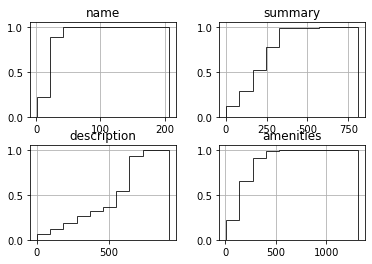

In [5]:
length = X_train_text.copy()

for col in length.columns:
    length[col] = length[col].apply(len)

for col in length.columns:
    d, v = np.histogram(length[col])
    c = np.cumsum(d)/length.shape[0]
    print (pd.DataFrame({col : v[1:], 'CDF' : c}), "\n") 

    # Exclude the starting value of bins so that the length of density and values match, 
    # the resulting data frame is in the format of: (ending value, CDF)

length.hist(density = True, cumulative = True, label='CDF',
             histtype = 'step', alpha=0.8, color = 'k')

In [6]:
name_pad_len = 63
summary_pad_len = 407
description_pad_len = 735
amenities_pad_len = 402

In [7]:
# name
name_tokenizer = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
name_tokenizer.fit_on_texts(X_train_text.name)
X_train_name_tokens = name_tokenizer.texts_to_sequences(X_train_text.name)

X_test_name_tokens = name_tokenizer.texts_to_sequences(X_test_text.name)
test_name_tokens = name_tokenizer.texts_to_sequences(test_text.name)

# summary
summary_tokenizer = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
summary_tokenizer.fit_on_texts(X_train_text.summary)
X_train_summary_tokens = summary_tokenizer.texts_to_sequences(X_train_text.summary)

X_test_summary_tokens = summary_tokenizer.texts_to_sequences(X_test_text.summary)
test_summary_tokens = summary_tokenizer.texts_to_sequences(test_text.summary)

# description
description_tokenizer = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
description_tokenizer.fit_on_texts(X_train_text.description)
X_train_description_tokens = description_tokenizer.texts_to_sequences(X_train_text.description)

X_test_description_tokens = description_tokenizer.texts_to_sequences(X_test_text.description)
test_description_tokens = description_tokenizer.texts_to_sequences(test_text.description)

# amenities
amenities_tokenizer = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
amenities_tokenizer.fit_on_texts(X_train_text.amenities)
X_train_amenities_tokens = amenities_tokenizer.texts_to_sequences(X_train_text.amenities)

X_test_amenities_tokens = amenities_tokenizer.texts_to_sequences(X_test_text.amenities)
test_amenities_tokens = amenities_tokenizer.texts_to_sequences(test_text.amenities)

In [8]:
padded_X_train_name = pad_sequences(X_train_name_tokens, name_pad_len)
padded_X_test_name = pad_sequences(X_test_name_tokens, name_pad_len)
padded_test_name = pad_sequences(test_name_tokens, name_pad_len)

padded_X_train_summary = pad_sequences(X_train_summary_tokens, summary_pad_len)
padded_X_test_summary = pad_sequences(X_test_summary_tokens, summary_pad_len)
padded_test_summary = pad_sequences(test_summary_tokens, summary_pad_len)

padded_X_train_description = pad_sequences(X_train_description_tokens, description_pad_len)
padded_X_test_description = pad_sequences(X_test_description_tokens, description_pad_len)
padded_test_description = pad_sequences(test_description_tokens, description_pad_len)

padded_X_train_amenities = pad_sequences(X_train_amenities_tokens, amenities_pad_len)
padded_X_test_amenities = pad_sequences(X_test_amenities_tokens, amenities_pad_len)
padded_test_amenities = pad_sequences(test_amenities_tokens, amenities_pad_len)

In [9]:
name_vocab_size = len(name_tokenizer.word_index) + 1
summary_vocab_size = len(summary_tokenizer.word_index) + 1
description_vocab_size = len(description_tokenizer.word_index) + 1
amenities_vocab_size = len(amenities_tokenizer.word_index) + 1

## 3.5 Embedding

After padding, each tokens are transformed into word embeddings (word vectors). Word Embedding is preferable over Bag-of-words because the distance between word vectors contain the relationships between words. For this assignment, a pretrained GloVe vectors is used.

In [10]:
glove = 'glove.6B.50d.txt'

glove_index = {}
start = time.time()
i = 0
with open(glove, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs
        i += 1
        #if i % 50000 == 0:
            #print('Read {} lines of embeddings in {} sec.'.format(i, time.time()-start))

In [11]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size, verbose=0):
    '''
        Helper function to construct an embedding matrix for 
        the focal corpus based on some pre-trained embeddings.
    '''
    
    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    
    emb_mat = np.zeros((vocab_size, dim))

    oov_words = []
    v = len(tokenizer.word_index)
    start = time.time()
    print('Start embedding process for {} words.'.format(v), flush=True)
    
    for word, i in tokenizer.word_index.items():  
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
        if i % 5000 == 0 and verbose>0:    
            print('{}/{} words in {} sec'.format(i, v, (time.time()-start)), flush=True)
            
            
    print('Created embedding matrix of shape {} in {} min '.format(emb_mat.shape, (time.time()-start)/60))
    
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [12]:
name_glove_weights, _ = get_embedding_matrix(name_tokenizer, glove_index, name_vocab_size)
summary_glove_weights, _ = get_embedding_matrix(summary_tokenizer, glove_index, summary_vocab_size)
description_glove_weights, _ = get_embedding_matrix(description_tokenizer, glove_index, description_vocab_size)
amenities_glove_weights, _ = get_embedding_matrix(amenities_tokenizer, glove_index, amenities_vocab_size)

Start embedding process for 4618 words.
Created embedding matrix of shape (4619, 50) in 0.0005163669586181641 min 
Encountered 956 out-of-vocabulary words.
Start embedding process for 14736 words.
Created embedding matrix of shape (14737, 50) in 0.0013324777285257975 min 
Encountered 3392 out-of-vocabulary words.
Start embedding process for 25626 words.
Created embedding matrix of shape (25627, 50) in 0.0015990813573201498 min 
Encountered 8312 out-of-vocabulary words.
Start embedding process for 273 words.
Created embedding matrix of shape (274, 50) in 0.00011659065882364908 min 
Encountered 1 out-of-vocabulary words.


In [13]:
nontext_colnames = X_train.columns # save the column names before it is lose in standardiser

Before proceeding further, all numeric features are standardised so that the network's learning considers all input fetures equally.

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test)

# 4. Model Evaluation

## 4.1.1 Linear Regression (LR)

When it comes to prediction using numeric features, the first that usually comes to mind is linear regression. Here, linear regression will be used as the benchmark model and the involvement of text features and neural network could be observed by seeing the changes in Mean Absolute Error (MAE) and Mean Squared Error (MSE) when comparing linear regression to some neural networks model.

In [110]:
linear_X_train = X_train.copy()
linear_X_train = pd.DataFrame(linear_X_train)
linear_X_train.columns = nontext_colnames
linear_X_train = sm.add_constant(linear_X_train)

linear_X_test = X_test.copy()
linear_X_test = pd.DataFrame(linear_X_test)
linear_X_test.columns = nontext_colnames
linear_X_test = sm.add_constant(linear_X_test)

In [112]:
model = sm.OLS(y_train, linear_X_train)
ols = model.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     3274.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:31:08   Log-Likelihood:            -2.4052e+05
No. Observations:               44227   AIC:                         4.811e+05
Df Residuals:                   44209   BIC:                         4.812e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [113]:
linear_val_prediction = ols.predict(linear_X_test)

A function that calculates Mean Absolute Error (MAE) and Mean Squared Error (MSE) is created to determine MAE and MSE of different models for comparison and selection.

In [20]:
def mae_mse(prediction, true):
    mae = np.mean(np.absolute(prediction - true))
    mse = np.mean(np.square(prediction - true))
    
    return (mae, mse)

In [169]:
val_linear_mae, val_linear_mse = mae_mse(linear_val_prediction, y_test)

## 4.1.2 LR with variable selection

Upon inspection of the linear regression summary, realized that 'host_has_profile_pic' and 'bed_type' have p-value that are more than 10%, thus they are statistically insignificance based on 10% significance level. Another linear regression model is being created excluding 'host_has_profile_pic' and 'bed_type':

In [117]:
# variable selection based on 5% significance level
selected_linear_X_train = linear_X_train.drop(['host_has_profile_pic', 'bed_type'], axis = 1)
selected_linear_X_test = linear_X_test.drop(['host_has_profile_pic', 'bed_type'], axis = 1)

In [170]:
selected_model = sm.OLS(y_train, selected_linear_X_train)
selected_ols = selected_model.fit()
print(selected_ols.summary())
selected_linear_val_prediction = selected_ols.predict(selected_linear_X_test)
val_selected_linear_mae, val_selected_linear_mse = mae_mse(selected_linear_val_prediction, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     3710.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:00:54   Log-Likelihood:            -2.4052e+05
No. Observations:               44227   AIC:                         4.811e+05
Df Residuals:                   44211   BIC:                         4.812e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [30]:
print('LR: \n MAE:', val_linear_mae, '\n MSE:', val_linear_mse, 
      '\n \n LR with variable selection: \n MAE:', val_selected_linear_mae, '\n MSE: ', val_selected_linear_mse)

LR: 
 MAE: 35.45916029837819 
 MSE: 3175.9641491388847 
 
 LR with variable selection: 
 MAE: 35.45368539839011 
 MSE:  3175.716181146826


Linear model using only statistical significant variable yields similar result compare to the one using 'host_has_profile_pic' and 'bed_type' as well, there are improvement but only very slightly.

# 4.2 Neural Network

After establishing the benchmark LR model, now several neural network models could be developed and compare to our benchmark. For RNNs' text features, it is decided that 'name', 'summary', 'description' and 'amenities' are to be included for full model while for some, only the 'summary' text feature is included for faster learning. As for activation function 'relu' is used because the target price is never negative.

Some of the models that have been done are:
1. Feedforward Neural Network (FNN)
2. Gated Reccurent Unit (GRU) with only summary
3. LSTM with full text features
4. Long Short-Term Memory (LSTM) with only summary
5. LSTM with full text features
6. Bidirectional LSTM (BiLSTM)

Note that not all Recurrent Neural Netowrks (RNNs) code are included in this jupyter notebook as they have similar structure and will only make the notebook more tedious to read. However, their MAE and MSE will be included during the model comparisons. Another notebook (RNNs.ipynb) is uploaded containing codes for those excluded session and simply copy and paste those part into this notebook if you wish to execute those parts.

# 4.2.1 FNN

In [119]:
inputs = layers.Input(shape=(X_train.shape[1],))
layer1 = layers.Dense(256,  activation = 'relu',
                      kernel_initializer=keras.initializers.he_normal(seed = 235), bias_initializer='zeros')(inputs)

layer2 = layers.Dense(128, activation = 'relu', 
                      kernel_initializer=keras.initializers.he_normal(seed = 235), bias_initializer='zeros')(layer1)

layer3 = layers.Dense(64, activation = 'relu', 
                      kernel_initializer=keras.initializers.he_normal(seed = 235), bias_initializer='zeros')(layer2)

layer4 = layers.Dense(32, activation = 'relu', 
                      kernel_initializer=keras.initializers.he_normal(seed = 235), bias_initializer='zeros')(layer3)

layer5 = layers.Dense(16, activation = 'relu', 
                      kernel_initializer=keras.initializers.he_normal(seed = 235), bias_initializer='zeros')(layer4)


predictions = layers.Dense(1, activation = 'relu')(layer5)

fnn = keras.Model(inputs = inputs, outputs = predictions)
fnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 256)               4608      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17    

In [120]:
opt = keras.optimizers.Adam(learning_rate=0.01) 

# fnn.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse', 'mae'])
fnn.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse', 'mae'])

batch_size = 128
epochs = 25


callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = fnn.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.25,
               callbacks=callbacks) 

Epoch 1/25
260/260 [==============================] - 2s 4ms/step - loss: 3455.3787 - mse: 3455.3787 - mae: 36.1573 - val_loss: 3160.9531 - val_mse: 3160.9531 - val_mae: 36.6797
Epoch 2/25
260/260 [==============================] - 1s 3ms/step - loss: 2987.0774 - mse: 2987.0774 - mae: 33.7168 - val_loss: 2856.0120 - val_mse: 2856.0120 - val_mae: 31.6170
Epoch 3/25
260/260 [==============================] - 1s 3ms/step - loss: 2923.4954 - mse: 2923.4954 - mae: 33.2649 - val_loss: 2794.3704 - val_mse: 2794.3704 - val_mae: 33.4036
Epoch 4/25
260/260 [==============================] - 1s 3ms/step - loss: 2857.3025 - mse: 2857.3025 - mae: 32.9817 - val_loss: 2774.2446 - val_mse: 2774.2446 - val_mae: 31.4385
Epoch 5/25
260/260 [==============================] - 1s 3ms/step - loss: 2839.9880 - mse: 2839.9880 - mae: 32.8668 - val_loss: 2749.5227 - val_mse: 2749.5227 - val_mae: 32.7869
Epoch 6/25
260/260 [==============================] - 1s 3ms/step - loss: 2828.6453 - mse: 2828.6453 - mae: 32

In [176]:
fnn_val_prediction = fnn.predict(X_test)
listing_id = pd.DataFrame(X_test_listing_id, columns = ["listing_id"])
fnn_val_prediction = pd.DataFrame(fnn_val_prediction, columns = ["price"])
fnn_val_prediction.describe()

346/346 [==============================] - 3s 3ms/step


,price
count,11057.000000
mean,107.762131
std,68.017258
min,15.356299
25%,51.011524
50%,94.037758
75%,142.047211
max,600.798340


The predictions from FNN seems to be in a plausible range and no resulting null prediction.

 # 4.2.2 GRU
 
As for RNN, GRU and Bidirectional LSTM are shown here because based on evaluation using X_test, these two performed better over all other models considered here. RNN is suitable for the task here because we have full text data for both train and test data and RNN will be able to recognise the patterns across the sequences.

In [18]:
input_name = Input(shape=(name_pad_len, ))
name_embeddings = Embedding(name_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(name_glove_weights),
                     input_length = name_pad_len, trainable = True)(input_name) 
GRU_name = GRU(25)(name_embeddings)
dense_name = Dense(1, activation ="linear")(GRU_name)


input_summary = Input(shape = (summary_pad_len, ))
summary_embeddings = Embedding(summary_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(summary_glove_weights),
                     input_length = summary_pad_len, trainable = True)(input_summary)
GRU_summary = GRU(100)(summary_embeddings)
dense_summary = Dense(1, activation ="linear")(GRU_summary)


input_description = Input(shape = (description_pad_len, ))
description_embeddings = Embedding(description_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(description_glove_weights),
                     input_length = description_pad_len, trainable = True)(input_description)
GRU_description = GRU(100)(description_embeddings)
dense_description = Dense(1, activation="linear")(GRU_description)


input_amenities = Input(shape = (amenities_pad_len, ))
amenities_embeddings = Embedding(amenities_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(amenities_glove_weights),
                     input_length = description_pad_len, trainable = True)(input_amenities)
GRU_amenities = GRU(100)(amenities_embeddings)
dense_amenities = Dense(1, activation="linear")(GRU_amenities)


input_nontext = Input(shape=(X_train.shape[1],))


# Concatenate
concat = concatenate([dense_name, dense_summary, dense_description, dense_amenities, input_nontext])
dense_full1 = Dense(256, activation = "relu")(concat)
dense_full2 = Dense(128, activation="relu")(dense_full1)
dense_full3 = Dense(64, activation="relu")(dense_full2)
output_layer = Dense(1, activation = "linear")(dense_full3)

model = Model(inputs=[input_name, input_summary, input_description, input_amenities, input_nontext], outputs = output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 63)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 407)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 735)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 402)]        0           []                               
                                                                                              

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.01) 

model.compile(optimizer = opt, loss='mean_squared_error', metrics=['mse', 'mae'])

start = time.time()

batch_size = 128
epochs = 25

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([padded_X_train_name, padded_X_train_summary, padded_X_train_description, padded_X_train_amenities, X_train], y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_split = 0.25,
                  callbacks = callbacks) 

end = time.time()

print(end - start)

Epoch 1/25
260/260 [==============================] - 1947s 7s/step - loss: 3406.3284 - mse: 3406.3284 - mae: 35.9482 - val_loss: 2908.2617 - val_mse: 2908.2617 - val_mae: 36.1614
Epoch 2/25
260/260 [==============================] - 2083s 8s/step - loss: 2488.1711 - mse: 2488.1711 - mae: 30.9196 - val_loss: 2817.3027 - val_mse: 2817.3027 - val_mae: 35.2737
Epoch 3/25
260/260 [==============================] - 2115s 8s/step - loss: 2008.9611 - mse: 2008.9611 - mae: 27.6247 - val_loss: 2556.6384 - val_mse: 2556.6384 - val_mae: 30.9675
Epoch 4/25
260/260 [==============================] - 2137s 8s/step - loss: 1655.8984 - mse: 1655.8984 - mae: 25.2366 - val_loss: 2894.1531 - val_mse: 2894.1531 - val_mae: 31.7742
Epoch 5/25
260/260 [==============================] - 2155s 8s/step - loss: 1430.2676 - mse: 1430.2676 - mae: 23.6333 - val_loss: 2854.5586 - val_mse: 2854.5586 - val_mae: 31.3858
Epoch 6/25
260/260 [==============================] - 2143s 8s/step - loss: 1251.6787 - mse: 1251.67

In [21]:
gru_val_prediction = model.predict([padded_X_test_name, padded_X_test_summary, padded_X_test_description, padded_X_test_amenities, X_test])
gru_val_prediction = pd.DataFrame(gru_val_prediction, columns = ["price"])
gru_val_result = pd.concat([X_test_listing_id, gru_val_prediction], axis = 1)

346/346 [==============================] - 92s 261ms/step


# 4.2.3 Bidirectional LSTM (BiLSTM)

In [141]:
input_name = Input(shape=(name_pad_len, ))
name_embeddings = Embedding(name_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(name_glove_weights),
                     input_length = name_pad_len, trainable = True)(input_name)   # try trainable False?
LSTM_name1 = Bidirectional(LSTM(25, return_sequences = False), merge_mode = 'concat')(name_embeddings)
dense_name = Dense(1, activation ="linear")(LSTM_name1)


input_summary = Input(shape = (summary_pad_len, ))
summary_embeddings = Embedding(summary_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(summary_glove_weights),
                     input_length = summary_pad_len, trainable = True)(input_summary)
LSTM_summary1 = Bidirectional(LSTM(100, return_sequences = False), merge_mode = 'concat')(summary_embeddings)
dense_summary = Dense(1, activation ="linear")(LSTM_summary1)


input_description = Input(shape = (description_pad_len, ))
description_embeddings = Embedding(description_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(description_glove_weights),
                     input_length = description_pad_len, trainable = True)(input_description)
LSTM_description1 = Bidirectional(LSTM(100, return_sequences = False), merge_mode = 'concat')(description_embeddings)
dense_description = Dense(1, activation="linear")(LSTM_description1)


input_amenities = Input(shape = (amenities_pad_len, ))
amenities_embeddings = Embedding(amenities_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(amenities_glove_weights),
                     input_length = description_pad_len, trainable = True)(input_amenities)
LSTM_amenities1 = Bidirectional(LSTM(100, return_sequences = False), merge_mode = 'concat')(amenities_embeddings)
dense_amenities = Dense(1, activation="linear")(LSTM_amenities1)


input_nontext = Input(shape=(X_train.shape[1],))


# Concatenate
concat = concatenate([dense_name, dense_summary, dense_description, dense_amenities, input_nontext])
# dense_full1 = Dense(256, activation = "relu")(concat)
dense_full2 = Dense(128, activation="relu")(concat) # (dense_full1)
dense_full3 = Dense(64, activation="relu")(dense_full2)
output_layer = Dense(1, activation = "linear")(dense_full3)

model = Model(inputs=[input_name, input_summary, input_description, input_amenities, input_nontext], outputs = output_layer)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 63)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 407)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 735)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 402)]        0           []                               
                                                                                            

In [142]:
opt = keras.optimizers.Adam(learning_rate=0.01) 

model.compile(optimizer = opt, loss='mean_squared_error', metrics=['mse', 'mae'])

start = time.time()

batch_size = 128
epochs = 25

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([padded_X_train_name, padded_X_train_summary, padded_X_train_description, padded_X_train_amenities, X_train], y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_split = 0.25,
                  callbacks = callbacks) 

end = time.time()

print(end - start)

Epoch 1/25
260/260 [==============================] - 9118s 35s/step - loss: 4628.7354 - mse: 4628.7354 - mae: 43.3041 - val_loss: 2998.5730 - val_mse: 2998.5730 - val_mae: 33.9816
Epoch 2/25
260/260 [==============================] - 10172s 39s/step - loss: 2911.0464 - mse: 2911.0464 - mae: 33.7629 - val_loss: 2799.9912 - val_mse: 2799.9912 - val_mae: 32.5115
Epoch 3/25
260/260 [==============================] - 10431s 40s/step - loss: 2494.3552 - mse: 2494.3552 - mae: 31.1039 - val_loss: 2665.5762 - val_mse: 2665.5762 - val_mae: 31.5786
Epoch 4/25
260/260 [==============================] - 10373s 40s/step - loss: 2125.6667 - mse: 2125.6667 - mae: 28.5542 - val_loss: 2782.5066 - val_mse: 2782.5066 - val_mae: 33.6522
Epoch 5/25
260/260 [==============================] - 10455s 40s/step - loss: 1848.5161 - mse: 1848.5161 - mae: 26.7494 - val_loss: 2854.8228 - val_mse: 2854.8228 - val_mae: 31.5665
Epoch 6/25
260/260 [==============================] - 10616s 41s/step - loss: 1687.5289 - m

In [143]:
bilstm_val_prediction = model.predict([padded_X_test_name, padded_X_test_summary, padded_X_test_description, padded_X_test_amenities, X_test])
listing_id = pd.DataFrame(X_test_listing_id, columns = ["listing_id"])
bilstm_val_prediction = pd.DataFrame(bilstm_val_prediction, columns = ["price"])
bilstm_val_prediction.describe()

346/346 [==============================] - 638s 2s/step


,price
count,11057.000000
mean,103.877930
std,65.880722
min,17.682997
25%,49.894409
50%,88.582153
75%,137.548981
max,576.065674


# 5. Model Comparison and selection

In [31]:
models_comparison = pd.read_csv("comparison.csv", sep = ",", encoding = "utf-8")
models_comparison

,Model,MAE,MSE
0,GRU,31.547228,2653.220379
1,BiLSTM,32.682837,2821.475437
2,GRU with summary only,32.750107,2832.827207
3,LSTM with summary only,32.888887,2916.223470
4,LSTM,33.006442,2807.883639
5,FNN,33.323926,2866.239236
6,LR with variable selection,35.453685,3175.716181
7,LR,35.459160,3175.964149


Comparing all considered models, most results are expected while some are not:
1. Linear Regression performed worst as it only include non-text features with variable selection improved it slightly.
2. FNN with only non-text features performed only better than linear regressions.
3. BiLSTM performed better than LSTM as it is more complex.
4. GRU with summary was included after seeing the unexpected result of LSTM with summary only perform better than full LSTM but it performs worst than full GRU which is to be expected.
5. GRU performs better than LSTM and BiLSTM is not expected since generally GRU uses less memory and is faster than LSTM but LSTM is more accurate when using datasets with longer sequences.

It is also understandable that the results of neural networks is affected by the randomness during training and GRU might not actually be the best one overall (since the mae and mse is not a lot lower than the others) but according to the model valuation using X_test and these training, GRU performed the best out of all considered model and thus are selected to be applied to Test Set.

# 6. GRU application to Test Set

After deciding for GRU, all train data should be combined together for model training so that we could use all available data more efficiently.

Firstly, check if mode of X (X_test and X_train combined before the splitting) and X_train are the same for 'host_since', 'host_total_listings_count','host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'bathrooms', 'bedrooms', 'beds'.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 934)

In [12]:
for col in ['host_since', 'host_total_listings_count','host_is_superhost','host_has_profile_pic', 
            'host_identity_verified', 'bathrooms', 'bedrooms', 'beds']:
    print(col, ': ', mode(X[col]) == mode(X_train[col]))

host_since :  True
host_total_listings_count :  True
host_is_superhost :  True
host_has_profile_pic :  True
host_identity_verified :  True
bathrooms :  True
bedrooms :  True
beds :  True


The editted non-text data can directly be combined since those replaced missing values will still be replaced by the same mode values after combining X_train and X_test again. y_train and y_test can be concatenated together directly since no changes are made to them. After that, all similar steps are performed again for the GRU while using train instead of X_train.

In [39]:
X_train = pd.read_csv("prepared_X_train.csv", sep=",", encoding = "utf-8")
X_test = pd.read_csv("prepared_X_test.csv", sep=",", encoding = "utf-8")
test = pd.read_csv("prepared_test.csv", sep=",", encoding = "utf-8")
# Intermediate result that couldn't be uploaded to moodle.
# These are the data after the data_preparation function in section 3.3
# Please let me know if needed and I would be happy to email them

train = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

train_text = train[['name', 'summary', 'description', 'amenities']]
test_text = test[['name', 'summary', 'description', 'amenities']]

for df in [train, test]:
    df = df.drop(['name', 'summary', 'description', 'amenities'], axis = 1, inplace = True)

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

    name       CDF
0   21.6  0.217567
1   42.2  0.884976
2   62.8  0.998788
3   83.4  0.999692
4  104.0  0.999910
5  124.6  0.999946
6  145.2  0.999946
7  165.8  0.999964
8  186.4  0.999982
9  207.0  1.000000 

   summary       CDF
0     83.8  0.118805
1    164.6  0.282306
2    245.4  0.520567
3    326.2  0.780714
4    407.0  0.986361
5    487.8  0.991191
6    568.6  0.992258
7    649.4  0.994537
8    730.2  0.998390
9    811.0  1.000000 

   description       CDF
0         93.0  0.062930
1        185.0  0.124882
2        277.0  0.185479
3        369.0  0.266261
4        461.0  0.314974
5        553.0  0.365042
6        645.0  0.548748
7        737.0  0.934104
8        829.0  0.997920
9        921.0  1.000000 

   amenities       CDF
0      139.7  0.215325
1      270.4  0.655832
2      401.1  0.904819
3      531.8  0.984064
4      662.5  0.996473
5      793.2  0.998589
6      923.9  0.999367
7     1054.6  0.999765
8     1185.3  0.999910
9     1316.0  1.000000 



array([[<AxesSubplot:title={'center':'name'}>,
        <AxesSubplot:title={'center':'summary'}>],
       [<AxesSubplot:title={'center':'description'}>,
        <AxesSubplot:title={'center':'amenities'}>]], dtype=object)

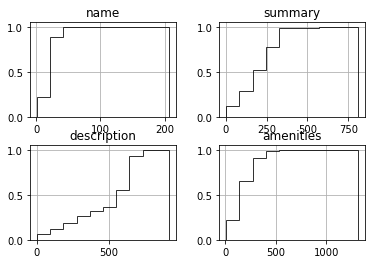

In [40]:
train_text = pd.concat([X_train_text, X_test_text])

train_length = train_text.copy()

for col in train_length.columns:
    train_length[col] = train_length[col].apply(len)

for col in train_length.columns:
    d, v = np.histogram(train_length[col])
    c = np.cumsum(d)/train_length.shape[0]
    print (pd.DataFrame({col : v[1:], 'CDF' : c}), "\n") 

    # Exclude the starting value of bins so that the length of density and values match, 
    # the resulting data frame is in the format of: (ending value, CDF)

train_length.hist(density = True, cumulative = True, label='CDF',
             histtype = 'step', alpha=0.8, color = 'k')

In [45]:
name_pad_len = 63
summary_pad_len = 407
description_pad_len = 737 # increased to 737 fom 735
amenities_pad_len = 402

In [47]:
# name
name_tokenizer = Tokenizer(oov_token = 1, filters = '!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower = False)
name_tokenizer.fit_on_texts(train_text.name)
train_name_tokens = name_tokenizer.texts_to_sequences(train_text.name)
test_name_tokens = name_tokenizer.texts_to_sequences(test_text.name)

# summary
summary_tokenizer = Tokenizer(oov_token = 1, filters = '!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower = False)
summary_tokenizer.fit_on_texts(train_text.summary)
train_summary_tokens = summary_tokenizer.texts_to_sequences(train_text.summary)
test_summary_tokens = summary_tokenizer.texts_to_sequences(test_text.summary)

# description
description_tokenizer = Tokenizer(oov_token = 1, filters = '!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower = False)
description_tokenizer.fit_on_texts(train_text.description)
train_description_tokens = description_tokenizer.texts_to_sequences(train_text.description)
test_description_tokens = description_tokenizer.texts_to_sequences(test_text.description)

# amenities
amenities_tokenizer = Tokenizer(oov_token = 1, filters = '!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower = False)
amenities_tokenizer.fit_on_texts(train_text.amenities)
train_amenities_tokens = amenities_tokenizer.texts_to_sequences(train_text.amenities)
test_amenities_tokens = amenities_tokenizer.texts_to_sequences(test_text.amenities)

# padding the sequences

padded_train_name = pad_sequences(train_name_tokens, name_pad_len)
padded_test_name = pad_sequences(test_name_tokens, name_pad_len)

padded_train_summary = pad_sequences(train_summary_tokens, summary_pad_len)
padded_test_summary = pad_sequences(test_summary_tokens, summary_pad_len)

padded_train_description = pad_sequences(train_description_tokens, description_pad_len)
padded_test_description = pad_sequences(test_description_tokens, description_pad_len)

padded_train_amenities = pad_sequences(train_amenities_tokens, amenities_pad_len)
padded_test_amenities = pad_sequences(test_amenities_tokens, amenities_pad_len)

name_vocab_size = len(name_tokenizer.word_index) + 1
summary_vocab_size = len(summary_tokenizer.word_index) + 1
description_vocab_size = len(description_tokenizer.word_index) + 1
amenities_vocab_size = len(amenities_tokenizer.word_index) + 1

# Load GloVe embeddings
glove = 'glove.6B.50d.txt'

glove_index = {}
start = time.time()
i = 0
with open(glove, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs
        i += 1
        #if i % 50000 == 0:
            #print('Read {} lines of embeddings in {} sec.'.format(i, time.time()-start))

name_glove_weights, _ = get_embedding_matrix(name_tokenizer, glove_index, name_vocab_size)
summary_glove_weights, _ = get_embedding_matrix(summary_tokenizer, glove_index, summary_vocab_size)
description_glove_weights, _ = get_embedding_matrix(description_tokenizer, glove_index, description_vocab_size)
amenities_glove_weights, _ = get_embedding_matrix(amenities_tokenizer, glove_index, amenities_vocab_size)

Start embedding process for 5127 words.
Created embedding matrix of shape (5128, 50) in 0.0009328206380208333 min 
Encountered 1110 out-of-vocabulary words.
Start embedding process for 16292 words.
Created embedding matrix of shape (16293, 50) in 0.004114282131195068 min 
Encountered 4089 out-of-vocabulary words.
Start embedding process for 28434 words.
Created embedding matrix of shape (28435, 50) in 0.0036977887153625487 min 
Encountered 9822 out-of-vocabulary words.
Start embedding process for 275 words.
Created embedding matrix of shape (276, 50) in 0.00016643206278483074 min 
Encountered 2 out-of-vocabulary words.


In [48]:
input_name = Input(shape=(name_pad_len, ))
name_embeddings = Embedding(name_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(name_glove_weights),
                     input_length = name_pad_len, trainable = True)(input_name) 
GRU_name = GRU(25)(name_embeddings)
dense_name = Dense(1, activation = "linear")(GRU_name)


input_summary = Input(shape = (summary_pad_len, ))
summary_embeddings = Embedding(summary_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(summary_glove_weights),
                     input_length = summary_pad_len, trainable = True)(input_summary)
GRU_summary = GRU(100)(summary_embeddings)
dense_summary = Dense(1, activation = "linear")(GRU_summary)


input_description = Input(shape = (description_pad_len, ))
description_embeddings = Embedding(description_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(description_glove_weights),
                     input_length = description_pad_len, trainable = True)(input_description)
GRU_description = GRU(100)(description_embeddings)
dense_description = Dense(1, activation = "linear")(GRU_description)


input_amenities = Input(shape = (amenities_pad_len, ))
amenities_embeddings = Embedding(amenities_vocab_size, output_dim=50,
                     embeddings_initializer = Constant(amenities_glove_weights),
                     input_length = description_pad_len, trainable = True)(input_amenities)
GRU_amenities = GRU(100)(amenities_embeddings)
dense_amenities = Dense(1, activation = "linear")(GRU_amenities)


input_nontext = Input(shape=(train.shape[1],))


# Concatenate
concat = concatenate([dense_name, dense_summary, dense_description, dense_amenities, input_nontext])
dense_full1 = Dense(256, activation = "relu")(concat)
dense_full2 = Dense(128, activation = "relu")(dense_full1)
dense_full3 = Dense(64, activation = "relu")(dense_full2)
output_layer = Dense(1, activation = "linear")(dense_full3)

model = Model(inputs=[input_name, input_summary, input_description, input_amenities, input_nontext], outputs = output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 63)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 407)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 737)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 402)]        0           []                               
                                                                                            

In [63]:
opt = keras.optimizers.Adam(learning_rate=0.01) 

model.compile(optimizer = opt, loss='mean_squared_error', metrics=['mse', 'mae'])

start = time.time()

batch_size = 128
epochs = 25

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([padded_train_name, padded_train_summary, padded_train_description, padded_train_amenities, train], y,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_split = 0.25,
                  callbacks = callbacks) 

end = time.time()

print(end - start)

Epoch 1/25
324/324 [==============================] - 3499s 11s/step - loss: 3137.8613 - mse: 3137.8613 - mae: 34.7104 - val_loss: 2760.3872 - val_mse: 2760.3872 - val_mae: 33.2894
Epoch 2/25
324/324 [==============================] - 3430s 11s/step - loss: 2528.3140 - mse: 2528.3140 - mae: 31.0423 - val_loss: 2664.8008 - val_mse: 2664.8008 - val_mae: 31.3687
Epoch 3/25
324/324 [==============================] - 3431s 11s/step - loss: 2216.3806 - mse: 2216.3806 - mae: 29.1086 - val_loss: 2766.3455 - val_mse: 2766.3455 - val_mae: 31.6267
Epoch 4/25
324/324 [==============================] - 3434s 11s/step - loss: 1985.3951 - mse: 1985.3951 - mae: 27.5033 - val_loss: 2754.1509 - val_mse: 2754.1509 - val_mae: 31.5457
Epoch 5/25
324/324 [==============================] - 3417s 11s/step - loss: 1841.8385 - mse: 1841.8385 - mae: 26.5433 - val_loss: 2812.0457 - val_mse: 2812.0457 - val_mae: 31.4987
Epoch 5: early stopping
17211.206006765366


Finally, the predictions are produced and concatenate with test_listing_id into the format required for submission and saved as a csv file.

In [64]:
gru_test_prediction = model.predict([padded_test_name, padded_test_summary, padded_test_description, padded_test_amenities, test])
gru_test_prediction = pd.DataFrame(gru_test_prediction, columns = ["price"])
gru_test_result = pd.concat([test_listing_id, gru_test_prediction], axis = 1)

931/931 [==============================] - 424s 454ms/step


In [65]:
gru_test_result.to_csv("C:/Users/felix/OneDrive/Desktop/ADAMS kaggle/gru_test_prediction.csv", index = False)

# 7. Conclusion

Through this assignment, it could be observed that the inclusion of NLP techniques and neural networks improved the prediction of price using non-text and text features.

It is clear that there are models that could perform better than the one shown here, for the improvement of data preparation, the non-english text could be translated into english instead of simply discarding them (in the case of reviews) or replacing them with 'non-english' (those in train data). The images from url links could also be included by using Convolutional Neural Network (CNN). Both Longtitude anf Latitude could also be used to determine the more exact location of the airbnb listing and whether it is a more expensive are (which can increase price prediction).

Given the time and computational power constraint, not all possibilities are being explored but overall it has been a great learning experience, learning the application of NLP techniques and Neural Networks working with real world data.